# COVIDNet-CXR-2 evaluation

* **WARNING:** This notebook requires TensorFlow 1.15 version, please downgrade before proceeding (original notebook was run in Google Colab environment where it is possible to switch between versions).

* The purpose of this notebook is to research and test the capabilities of the current state-of-the-art model for COVID-19 detection.
* The chosen model is the COVIDNet-CXR-2 model, available at https://github.com/lindawangg/COVID-Net.
* The model was trained on the COVIDx8B dataset for binary detection of 'positive' and 'negative' chest X-ray images. It is currently the best model for performing this task on this dataset to our knowledge.
* We also evaluate an older version of the COVID-Net architecture called the COVID-Net CXR3-B, which was trained on an old version of the dataset COVIDx3 for categorical classification of 'normal', 'COVID-19', and 'pneumonia' images. This thesis is focused on automatic diagnosis of COVID-19, so we will filter the evaluation process to only consider images that are COVID-19 'positive' or 'negative' by taking the maximum of the two pneumonia predictions and using it in place of the 'positive' class's prediction.
* Both models are evaluated on both of the versions of the dataset to test their generalization ability.
* The models are available at https://github.com/lindawangg/COVID-Net/blob/master/docs/models.md.

*Author: Dominik Chodounský, FIT CTU in Prague (Last edit: 05/11/21)*

## Imports and Colab session settings
* Due to the origin of the evaluated model, we must downgrade TensorFlow to version 1.15

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import cv2
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import numpy as np
import os
import sys

## Constants and Settings
* Set variables *TEST_DIR* to contain paths to the specific test sets of each dataset version.

In [2]:
ROOT_PATH = '../'
x8_TEST_DIR = os.path.join(ROOT_PATH, 'data/COVIDx8B/test')
x3_TEST_DIR = os.path.join(ROOT_PATH, 'data/COVIDx3/test')

RAND_SEED = 111 # random seed for reproducibility

# ------------------------------------------------------------------------------------------------------------------------#
np.random.seed(RAND_SEED)
tf.compat.v1.set_random_seed(RAND_SEED)
random.seed(RAND_SEED)
os.environ['PYTHONHASHSEED'] = str(RAND_SEED)

warnings.filterwarnings("ignore")

## File Imports
* Imports files containing helper functions, preprocessing functions, etc.

In [3]:
from preprocessing.covid_net_preprocessing import *
from utils.utils import create_dataframe, get_generators, get_class_weights, plot_eval

* Define necessary functions for evaluating the provided models.

In [4]:
def covid_net_prediction_binary(img_path, graph, session, args, verbose=False):
    """
    Returns the prediction of a model that performs binary classification on a specific CXR image.
    Function is based on original COVID-Net paper and corresponding GitHub repo: https://github.com/lindawangg/COVID-Net/blob/master/inference.py
    
    Parameters
    ----------
    img_path : str
        Path to the image to perform the pridction on.
    graph : TensorFlow.Graph
        TensorFlow graph of the model to perform the prediction with.
    session : TensorFlow.Session
        TensorFlow session to run the prediction in.
    args : dict
        Dictionary of arguments that specify the model and its parameters.
    verbose : bool
        Whether to print the final predictions. Default value: False.

    Returns
    -------
    pred : (str, float)
        Tuple where first element is the predicted class and the second element is the predicted probability.
    """

    mapping = {0: 'negative', 1: 'positive'}

    image_tensor = graph.get_tensor_by_name(args['in_tensorname'])
    pred_tensor = graph.get_tensor_by_name(args['out_tensorname'])

    x = process_image_file(img_path, args['top_percent'], args['input_size'])
    x = x.astype('float32') / 255.0
    pred = session.run(pred_tensor, feed_dict={image_tensor: np.expand_dims(x, axis=0)})[0]
    
    if verbose:
        print('Prediction: {}'.format(mapping[pred.argmax()]))
        print('Confidence')
        print('Negative (Normal): {:.3f}, Positive (Pneumonia): {:.3f}'.format(pred[0], pred[1]))
    return mapping[pred.argmax()], pred[1]


def covid_net_prediction_categorical(img_path, graph, session, args, verbose=False):
    """
    Returns the binary prediction of a model that was built to perform categorical classification on a specific CXR image.
    The pulmonary diseases are combined by taking their maximum probability estimate.
    Function is based on original COVID-Net paper and corresponding GitHub repo: https://github.com/lindawangg/COVID-Net/blob/master/inference_pneumonia.py
    
    Parameters
    ----------
    img_path : str
        Path to the image to perform the pridction on.
    graph : TensorFlow.Graph
        TensorFlow graph of the model to perform the prediction with.
    session : TensorFlow.Session
        TensorFlow session to run the prediction in.
    args : dict
        Dictionary of arguments that specify the model and its parameters.
    verbose : bool
        Whether to print the final predictions. Default value: False.

    Returns
    -------
    pred : (str, float)
        Tuple where first element is the predicted class and the second element is the predicted probability.
    """
    mapping = {0: 'negative', 1: 'positive'}

    image_tensor = graph.get_tensor_by_name(args['in_tensorname'])
    pred_tensor = graph.get_tensor_by_name(args['out_tensorname'])

    x = process_image_file(img_path, args['top_percent'], args['input_size'])
    x = x.astype('float32') / 255.0

    pred = session.run(pred_tensor, feed_dict={image_tensor: np.expand_dims(x, axis=0)})
    pred_pneumonia = np.array([pred[0][0], np.max([pred[0][1], pred[0][2]])]) # combine pneumonia and covid predictions into single pneumonia prediction -> to get binary covid detection
    pred_pneumonia = pred_pneumonia / np.sum(pred_pneumonia)

    if verbose:
        print('Prediction: {}'.format(mapping[pred_pneumonia.argmax()]))
        print('Confidence')
        print('Negative (Normal): {:.3f}, Positive (Pneumonia): {:.3f}'.format(pred_pneumonia[0], pred_pneumonia[1]))
    return mapping[pred_pneumonia.argmax()], pred_pneumonia[1]


def evaluate_covidnet(model_dict, data_df, data_path, type='binary'):
    """
    Returns the binary prediction of a model that was built to perform categorical classification on a specific CXR image.
    The pulmonary diseases are combined by taking their maximum probability estimate.
    Function is based on original COVID-Net paper and corresponding GitHub repo: https://github.com/lindawangg/COVID-Net/blob/master/inference_pneumonia.py
    
    Parameters
    ----------
    model_dict : dict
        Dictionary of arguments that specify the model and its parameters.
    data_df : pandas.DataFrame
        DataFrame containing the names and labels of the data for evaluation.
    data_path : str
        Path to the directory with the data for evaluation.
    type : str
        Specifies whether the tested model was originally built for 'binary' or 'categorical' classification. Default value: binary.

    Returns
    -------
    pred : (str, float)
        Tuple where first element is an array of ground truth labels for the evaluated data and the second element contains the model's probability predictions.
    """

    new_graph = tf.Graph()
    with tf.Session(graph=new_graph) as sess:
        tf.get_default_graph()
        saver = tf.train.import_meta_graph(os.path.join(model_dict['weightspath'], model_dict['metaname']))
        saver.restore(sess, os.path.join(model_dict['weightspath'], model_dict['ckptname']))
        covid_net = tf.get_default_graph()

        total, correct, y_true, y_pred_prob = 0, 0, [], []
        for index, row in data_df.iterrows():
            img = os.path.join(data_path, row['path'])
            if type == 'binary':
                pred = covid_net_prediction_binary(img_path=img, graph=covid_net, session=sess, args=model_dict, verbose=False)
            elif type == 'categorical':
                pred = covid_net_prediction_categorical(img_path=img, graph=covid_net, session=sess, args=cxr3B, verbose=False)
            if row['label'] == pred[0]:
                correct += 1
            if row['label'] == 'positive':
                y_true.append(1)
            else:
                y_true.append(0)
            y_pred_prob.append(pred[1])
            total += 1
        print(f"\nAccuracy of model {model_dict['name']} on the test set was: {correct/total:.2%}")

    tf.reset_default_graph()
    return np.asarray(y_true), np.asarray(y_pred_prob)

## Test COVID-Net CXR-2 on COVIDx8B

* Store test data in a DataFrame in order to make testing more organized.

In [5]:
x8_test_df = create_dataframe(x8_TEST_DIR)

<AxesSubplot:xlabel='label', ylabel='count'>

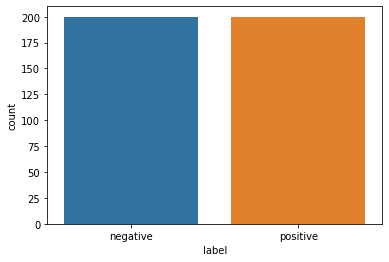

In [6]:
sns.countplot(x8_test_df['label'], order=['negative', 'positive'])

* Dictionary containing information needed to load and evaluate the model.

In [9]:
cxr2 = {
    'name': 'COVID-Net CXR-2',
    'weightspath': os.path.join(ROOT_PATH, 'models/CNN/COVID-Net CXR-2'),
    'metaname': 'model.meta',
    'ckptname': 'model',
    'in_tensorname': 'input_1:0',
    'out_tensorname': 'norm_dense_2/Softmax:0',
    'input_size': 480,
    'top_percent': 0.08
}

* Evaluation loop
    * Loads model with weights as a TensorFlow graph.
    * Iterates over test data stored in the testing DataFrame and evaluates the accuracy of the predictions.

In [ ]:
y_true, y_pred_prob = evaluate_covidnet(cxr2, x8_test_df, x8_TEST_DIR, 'binary')

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/ColabNotebooks/BI-BAP/models/CNN/COVID-Net CXR-2/model

Accuracy of model COVID-Net CXR-2 on the test set was: 96.25%


* *(Note: Accuracy on the COVIDx8B training set was measured to be 96.07 %)*

In [ ]:
# calculation of other evaluation metrics
y_pred = y_pred_prob.copy()
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Specificity (TPR), Sensitivity (TNR), Positive Predictive Value (PPV)
tp/(tp+fn), tn/(tn+fp), tp/(tp+fp)

(0.955, 0.97, 0.9695431472081218)

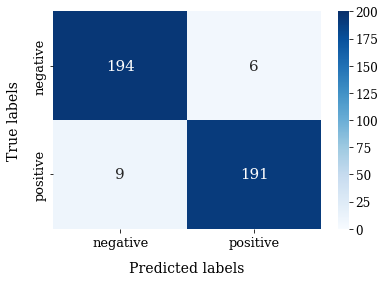

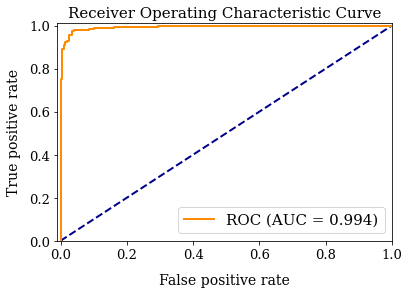

In [ ]:
plot_eval(y_true, y_pred_prob, y_pred)

## Test COVID-Net CXR3-B on COVIDx3

* Store test data in a DataFrame in order to make testing more organized.

In [ ]:
x3_test_df = create_dataframe(x3_TEST_DIR)

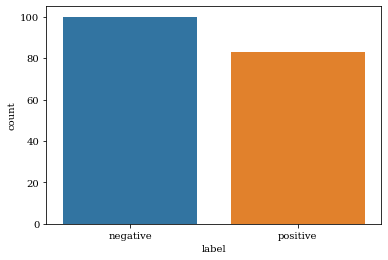

In [ ]:
sns.countplot(x3_test_df['label'], order=['negative', 'positive'])

* Dictionary containing information needed to load and evaluate the model.

In [ ]:
cxr3B = {
    'name': 'COVIDNet-CXR3-B',
    'weightspath': os.path.join(ROOT_PATH, 'models/CNN/COVIDNet-CXR3-B'),
    'metaname': 'model.meta',
    'ckptname': 'model-1014',
    'in_tensorname': 'input_1:0',
    'out_tensorname': 'norm_dense_1/Softmax:0',
    'input_size': 480,
    'top_percent': 0.08
}

In [ ]:
y_true, y_pred_prob = evaluate_covidnet(cxr3B, x3_test_df, x3_TEST_DIR, 'categorical')

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/ColabNotebooks/BI-BAP/models/CNN/COVIDNet-CXR3-B/model-1014

Accuracy of model COVIDNet-CXR3-B on the test set was: 96.17%


* *(Note: Accuracy on the COVIDx3 training set was measured to be 96.07 %)*

In [ ]:
# calculation of other evaluation metrics
y_pred = np.asarray(y_pred_prob.copy())
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Specificity (TPR), Sensitivity (TNR), Positive Predictive Value (PPV)
tp/(tp+fn), tn/(tn+fp), tp/(tp+fp)

(0.9759036144578314, 0.95, 0.9418604651162791)

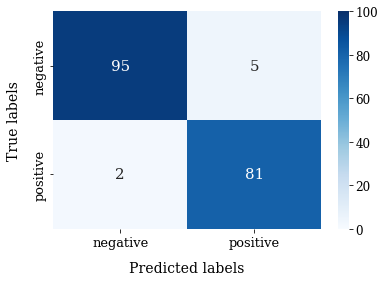

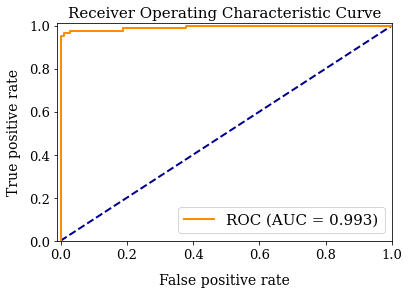

In [ ]:
plot_eval(y_true, y_pred_prob, y_pred)

# Test new COVID-Net CXR-2 on the old COVIDx3 dataset

In [ ]:
y_true, y_pred_prob = evaluate_covidnet(cxr2, x3_test_df, x3_TEST_DIR, 'binary')

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/ColabNotebooks/BI-BAP/models/CNN/COVID-Net CXR-2/model

Accuracy of model COVID-Net CXR-2 on the test set was: 93.99%


* *(Note: Accuracy on the COVIDx3 training set was measured to be 99.51 %)*

In [ ]:
# calculation of other evaluation metrics
y_pred = np.asarray(y_pred_prob.copy())
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Specificity (TPR), Sensitivity (TNR), Positive Predictive Value (PPV)
tp/(tp+fn), tn/(tn+fp), tp/(tp+fp)

(0.8795180722891566, 0.99, 0.9864864864864865)

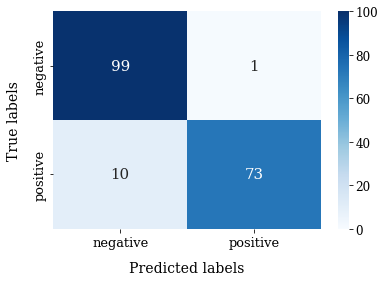

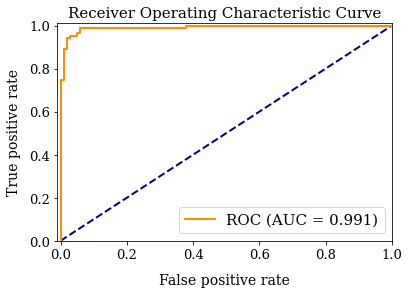

In [ ]:
plot_eval(y_true, y_pred_prob, y_pred)

# Test old COVID-Net CXR3-B on the new COVIDx8B dataset

In [ ]:
y_true, y_pred_prob = evaluate_covidnet(cxr3B, x8_test_df, x8_TEST_DIR, 'categorical')

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/ColabNotebooks/BI-BAP/models/CNN/COVIDNet-CXR3-B/model-1014

Accuracy of model COVIDNet-CXR3-B on the test set was: 71.50%


* *(Note: Accuracy on the COVIDx8B training set was measured to be 61.44 %)*

In [ ]:
# calculation of other evaluation metrics
y_pred = np.asarray(y_pred_prob.copy())
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Specificity (TPR), Sensitivity (TNR), Positive Predictive Value (PPV)
tp/(tp+fn), tn/(tn+fp), tp/(tp+fp)

(0.93, 0.5, 0.6503496503496503)

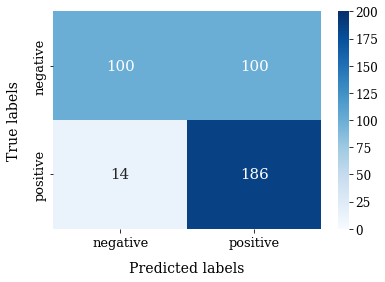

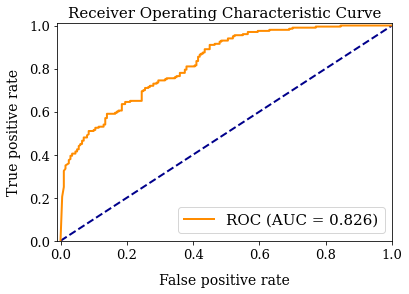

In [ ]:
plot_eval(y_true, y_pred_prob, y_pred)

## Calculate intersection of the two test sets
* Since there is a very large discrepancy between the model's performance on the two test sets, it may be interesting to analyze the size of their intersection.

In [8]:
x3_df = create_dataframe(x3_TEST_DIR)

In [9]:
count = 0
intersect = 0
for index, row in x3_df.iterrows():
    if os.path.exists(os.path.join(os.path.join(ROOT_PATH, 'data/COVIDx8B/test'), row['path'])):
        intersect += 1
    count += 1

print(f'Out of {count} images in the COVIDx3 test set, {intersect} of them are also in the COVIDx8B test set. The intersection is around {intersect/count:.2%}')

Out of 183 images in the COVIDx3 test set, 100 of them are also in the COVIDx8B test set. The intersection is around 54.64%




---



# COVID-Net Evaluation Results

| Model architecture | Dataset version | Train accuracy | Test accuracy | COVID-19 Sensitivity | COVID-19 Specificity | AUC | PPV |
|-------|-------|-------|-------|-------|-------|-------|-------|
|COVID-Net CXR2|COVIDx8B| 0.9607|0.9625|0.955|0.97|0.994|0.9695|
|COVID-Net CXR2|COVIDx3| 0.9951|0.9399|0.8795|0.99|0.991|0.9865|
|COVID-Net CXR3-B|COVIDx8B|0.6144|0.7150|0.93|0.50|0.0.826|0.6503|
|COVID-Net CXR3-B|COVIDx3|0.9607|0.9617|0.9759|0.95|0.993|0.9419|


